# APOD fake and real image classification 

## Preparing Input Data 

Activities performed:
*   The data is downloaded as zip files from external sources and saved to drive
*   The zip files are copied to local workspace in collab
*   Unzipping the data into folders







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cp "/content/drive/MyDrive/APOD_data/APOD_Train.zip" .


In [3]:
cp "/content/drive/MyDrive/APOD_data/APOD_Valid.zip" .


In [4]:

!unzip APOD_Train.zip -d training
!unzip APOD_Valid.zip -d validation

Streaming output truncated to the last 5000 lines.
  inflating: training/__MACOSX/APOD_Train/Fake/._01193.png  
  inflating: training/APOD_Train/Fake/1636371984_00300.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_00300.png  
  inflating: training/APOD_Train/Fake/01178.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._01178.png  
  inflating: training/APOD_Train/Fake/00500.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._00500.png  
  inflating: training/APOD_Train/Fake/1636371984_01787.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_01787.png  
  inflating: training/APOD_Train/Fake/1636371984_00499.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_00499.png  
  inflating: training/APOD_Train/Fake/00514.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._00514.png  
  inflating: training/APOD_Train/Fake/1636371984_01962.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_01962.png  
  inflating: training/A

## Data Loading

Activities performed:
* create generators by loading the training and validation data from the local workspace
* mentioning the batch size and image size for processing

In [5]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00


In [6]:
# Import modules
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt


In [7]:
# Parameters
IMG_SIZE = 224
IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)
BATCH_SIZE = 32
EPOCHS = 50
STEPS = 10

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training/APOD_Train/",
    shuffle=True, batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE
)

Found 7000 files belonging to 2 classes.


In [9]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "validation/APOD_Valid/",
    shuffle=True, batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE
)

Found 2183 files belonging to 2 classes.


## Input Data Visualisation

Activities Performed:
* Understanding the shape of the image 
* Explored the class distribution in the training data 
* Plotted few samples of training data from both classes 

In [10]:
class_names = train_dataset.class_names
class_names

['Fake', 'Real']

In [11]:
# min max scaling 
def min_max_scale(image):
  image = (image - image.min()) / (image.max() - image.min()) 
  return image

In [12]:
for image, label in train_dataset.take(1):
    print("Shape of the input images batch: ", image.shape)

Shape of the input images batch:  (32, 224, 224, 3)


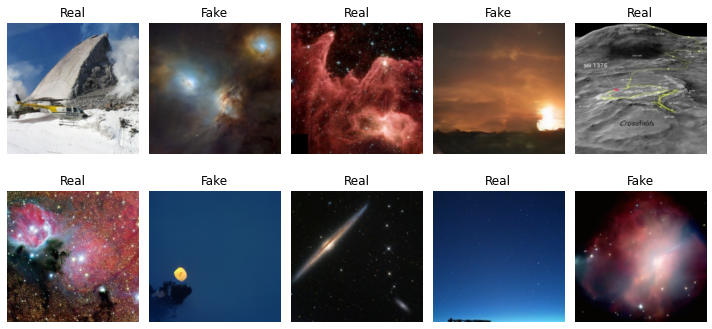

In [29]:
# training data samples
images, labels = next(iter(train_dataset))
i = 0
plt.figure(figsize = (10,5))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(min_max_scale(images[i].numpy()))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.tight_layout()

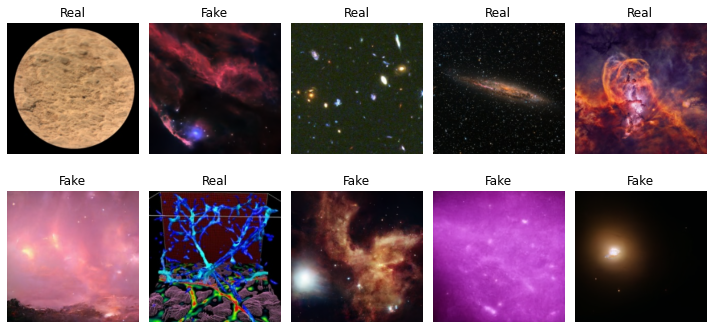

In [14]:
# validation dataset samples
images, labels = next(iter(valid_dataset))
i = 0
plt.figure(figsize = (10,5))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(min_max_scale(images[i].numpy()))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.tight_layout()

## Data Processing Pipeline

* Create image processing pipeline for training and validation dataset

In [15]:
# Image Preprocessing functions. You should aim to optimise these in Exercise 2.

def img_process_train(image, label):
    """
    A preprocessing fuction for the training dataset. This function accepts the
    oxford_iiit_pet dataset, extracts the images and species label, the performs
    random augmentations before resizing and rescaling the images.
    """

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)
    
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, 'float32')/255.

    return image, label

def img_process_test(image, label):
    """
    A preprocessing fuction for the test and validation datasets. This function
    accepts the oxford_iiit_pet dataset, extracts the images and species label,
    and resizes and rescales the images.
    """
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, 'float32')/255.
    return image, label


In [16]:
train_ds = (
    train_dataset
    .map(img_process_train, num_parallel_calls=tf.data.AUTOTUNE)  
    .prefetch(tf.data.AUTOTUNE)  
)

# Validation images are only parsed with the processing function
val_ds = (
    valid_dataset
    .map(img_process_test)
)

## Model Building

* Loading Pretrained VGGNet model with imagenet weights
* Locking the layers of the pretrained models except the last fully connected layer
* Adding the compiler information 

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=IMAGE_SIZE+(3,)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='elu',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='elu',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.summary()

# Adam optimiser
opt = tf.keras.optimizers.Adam()

# Accuracy metric
metrics = ['accuracy']

# Compile model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                        

## Model Training

In [18]:
# Adding early stopping callback to avoid overfitting of the model
early_callback = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [19]:
# Train the Model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[early_callback])

Epoch 1/50
219/219 [==============================] - 55s 195ms/step - loss: 0.5266 - accuracy: 0.7670 - val_loss: 0.4540 - val_accuracy: 0.7994
Epoch 2/50
219/219 [==============================] - 41s 184ms/step - loss: 0.3566 - accuracy: 0.8397 - val_loss: 0.3830 - val_accuracy: 0.8397
Epoch 3/50
219/219 [==============================] - 42s 191ms/step - loss: 0.3264 - accuracy: 0.8526 - val_loss: 0.3730 - val_accuracy: 0.8415
Epoch 4/50
219/219 [==============================] - 41s 184ms/step - loss: 0.3135 - accuracy: 0.8597 - val_loss: 0.4344 - val_accuracy: 0.8369
Epoch 5/50
219/219 [==============================] - 41s 186ms/step - loss: 0.2994 - accuracy: 0.8676 - val_loss: 0.3777 - val_accuracy: 0.8438
Epoch 6/50
219/219 [==============================] - 43s 193ms/step - loss: 0.2973 - accuracy: 0.8646 - val_loss: 0.4349 - val_accuracy: 0.8346
Epoch 7/50
219/219 [==============================] - 43s 192ms/step - loss: 0.2782 - accuracy: 0.8799 - val_loss: 0.4634 - val_ac

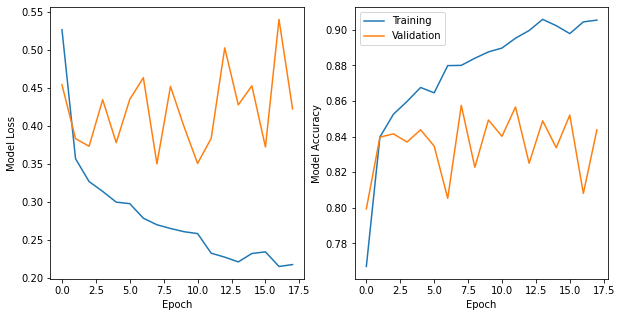

In [20]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_ylabel('Model Loss')
ax[0].set_xlabel('Epoch')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Epoch')
plt.legend()


## Prediction

In [21]:
image_batch, label_batch = next(iter(valid_dataset))

# make predictions on test dataset
y_prob = model.predict(image_batch)


1/1 [==============================] - 0s 109ms/step


In [22]:
# glimpse of probabilities
y_prob

array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.9467620e-24, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [8.1269817e-12, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [2.3923303e-09, 1.0000000e+00],
       [8.7373741e-16, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [3.4847980e-36, 1.

In [23]:
# choosing the label with max probability 
[i.argmax() for i in y_prob]

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

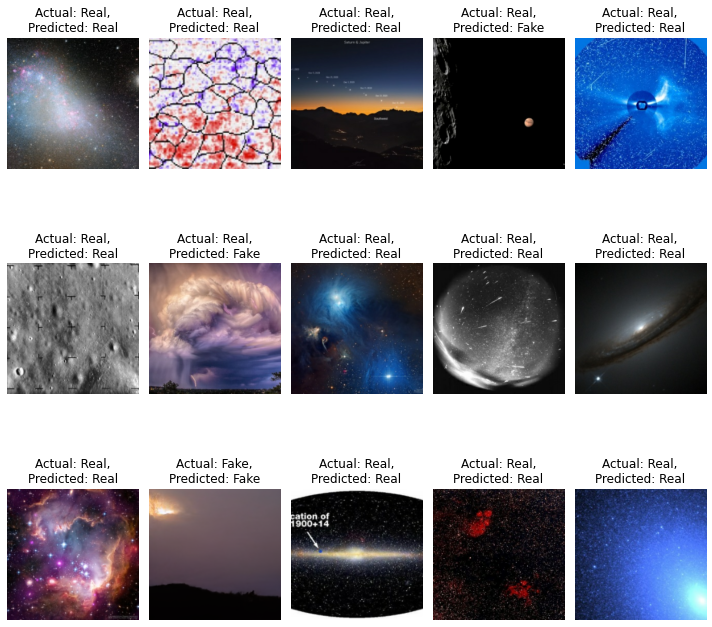

In [24]:

# visualize 10 images from dataset
plt.figure(figsize=(10,10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    img = image_batch[i].numpy()
    scaled_img = min_max_scale(img) 
    plt.imshow(scaled_img)
    plt.axis("off")
    y_class = y_prob[i].argmax()
    plt.title(f'Actual: {class_names[label_batch[i]][:10]},'
              f'\nPredicted: {class_names[y_class][:10]}')
plt.tight_layout()

## Saving the model

In [25]:
model.save("/content/APOD/model")

In [26]:
!zip -r /content/APOD/model.zip /content/APOD/model

  adding: content/APOD/model/ (stored 0%)
  adding: content/APOD/model/assets/ (stored 0%)
  adding: content/APOD/model/variables/ (stored 0%)
  adding: content/APOD/model/variables/variables.index (deflated 66%)
  adding: content/APOD/model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/APOD/model/saved_model.pb (deflated 89%)
  adding: content/APOD/model/keras_metadata.pb (deflated 92%)


In [27]:
from google.colab import files
files.download("/content/APOD/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>